<a href="https://colab.research.google.com/github/seansothey/CSC685/blob/master/Project6_Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [68]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import time

# to make this notebook's output stable across runs
np.random.seed(42)

from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

'0.22.2.post1'

# Clustering Bridge Image Dataset

##Data Scrubing

## Loading Data

In [0]:
bridge = pd.read_csv('https://raw.githubusercontent.com/seansothey/CSC685/master/bridge.txt', delim_whitespace=True, header=None) #avoid spaces separated

In [3]:
bridge.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,6,8,6,9,0,0,0,0,0,0,0,0,0,0,0,0
1,7,4,3,4,0,0,0,0,0,0,0,0,0,0,0,0
2,8,8,8,18,31,12,22,34,74,74,68,60,96,99,104,79
3,9,9,16,34,11,15,38,54,60,22,65,75,99,78,92,114
4,9,19,34,39,23,26,31,39,16,31,34,41,59,63,33,38


In [4]:
bridge.shape

(4096, 16)

In [5]:
bridge.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
dtype: int64

In [0]:
bridge_np = np.array(bridge) #convert dataframe to numpy array

In [7]:
bridge_np

array([[  6,   8,   6, ...,   0,   0,   0],
       [  7,   4,   3, ...,   0,   0,   0],
       [  8,   8,   8, ...,  99, 104,  79],
       ...,
       [251, 247, 243, ..., 127, 141, 153],
       [252, 250, 249, ...,  92,  94,  99],
       [253, 224, 209, ..., 246, 233, 227]])

In [0]:
bridge4x4 = bridge_np.reshape(4096,4,4)

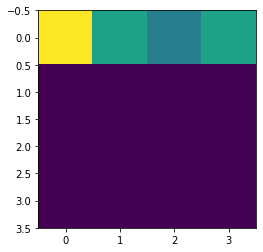

In [9]:
plt.imshow(bridge4x4[1]) #view the image index 1

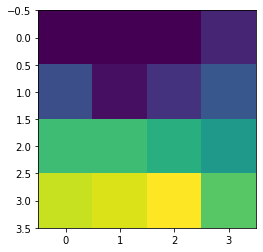

In [10]:
plt.imshow(bridge4x4[2]) #view the image index 2

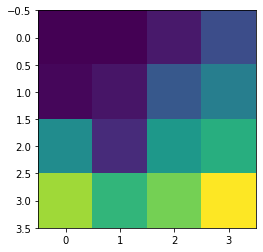

In [11]:
plt.imshow(bridge4x4[3]) #view the image index 3

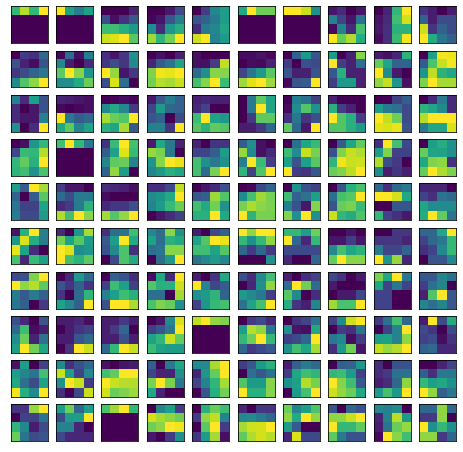

In [12]:
# See 100 images
plt.figure(figsize=(8,8))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(bridge4x4[i])

Text(0.5, 1.0, 'Bridge Dataset')

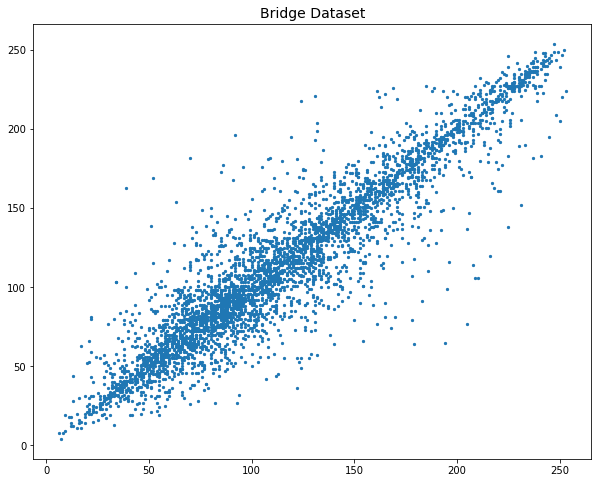

In [13]:
# See the whole dataset in 2d axis 
plt.figure(figsize=(10,8))
plt.scatter(bridge_np[:,0], bridge_np[:,1], s=5)
plt.title("Bridge Dataset", fontsize=14)

Generate isotropic Gaussian blobs for clustering

In [0]:
X_bridge, y_bridge = make_blobs(n_samples=len(bridge), random_state=42)

In [15]:
np.unique(y_bridge) #See how many labels was generated

array([0, 1, 2])

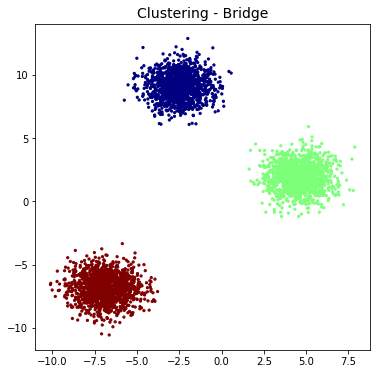

In [16]:
# Plot see the brief clusters 
plt.figure(figsize=(6,6))
plt.scatter(X_bridge[:, 0], X_bridge[:, 1], c=y_bridge, s=5, cmap='jet')
plt.title("Clustering - Bridge", fontsize=14)
plt.show()

Therefore, the number of clusters should be 3.

##Plot K-Elbow

In [0]:
kmeans=[KMeans(n_clusters=k, random_state=42).fit(X_bridge) for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans]

Text(0.5, 1.0, 'K - Elbow')

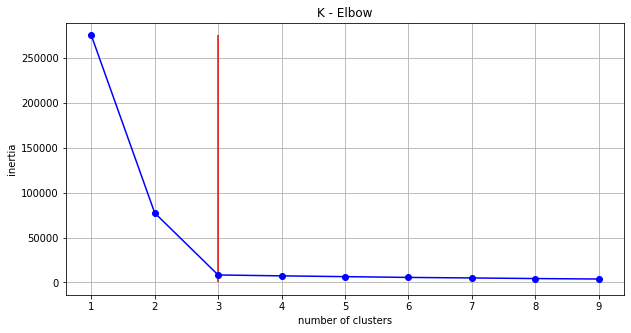

In [18]:
ax=plt.figure(figsize=(10,5))
plt.plot(range(1,10),inertias,"bo-")
plt.xlabel("number of clusters")
plt.ylabel("inertia")
plt.grid(True)
plt.vlines(3,0,np.max(inertias),color='red')
plt.title("K - Elbow")

As expected, the elbow point is k=3

## Plot the silhouette score vs performance of $k$

In [0]:
silhouette_scores = [silhouette_score(X_bridge, model.labels_)
                     for model in kmeans[1:]]
best_index = np.argmax(silhouette_scores)
best_score = silhouette_scores[best_index]
best_model = kmeans[best_index]

Text(0.5, 1.0, 'Performance of $K$')

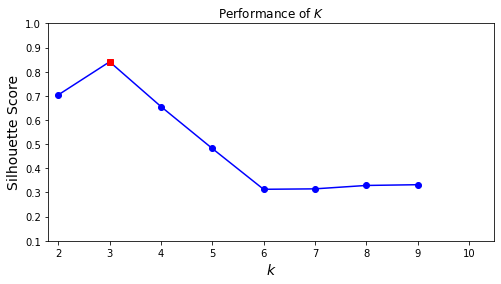

In [20]:
plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.plot(3, best_score, "rs")
plt.axis([1.8, 10.5, 0.1, 1.0])
plt.title("Performance of $K$")

This visualization is clear to confirms that $k=3$ is the best choice.

## K-Means Clustering

### Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [0]:
kmodel = KMeans(n_clusters=3, random_state=42)

In [0]:
y = kmodel.fit_predict(X_bridge)

In [23]:
y

array([2, 0, 0, ..., 2, 0, 0], dtype=int32)

In [25]:
len(y)

4096

In [26]:
y is kmodel.labels_

True

Therefore, y_pred is the label (0, 1, 2) tha represents for each cluster.

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to:

In [27]:
kmodel.labels_

array([2, 0, 0, ..., 2, 0, 0], dtype=int32)

Of course, we can predict the labels of new instances:

### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

In [0]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

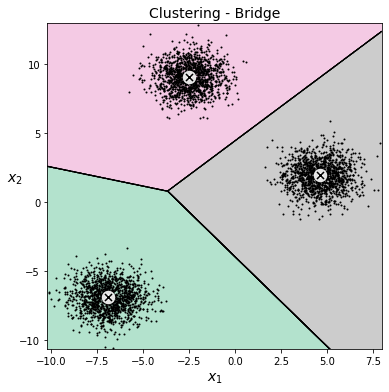

In [29]:
plt.figure(figsize=(6, 6))
plot_decision_boundaries(kmodel, X_bridge)
plt.title("Clustering - Bridge", fontsize=14)
plt.show()

##With RandomForest Classifier

## Spliting data for training and testing set in ratio 70%-30%

In [0]:
X_bridge_train, X_bridge_test, y_bridge_train, y_bridge_test = train_test_split(X_bridge, y, test_size=0.3, shuffle = True, random_state=42)

In [31]:
X_bridge_train.shape, X_bridge_test.shape, y_bridge_train.shape, y_bridge_test.shape

((2867, 2), (1229, 2), (2867,), (1229,))

Create the model and fit with the training set

In [32]:
from sklearn.ensemble import RandomForestClassifier

RF_bridge = RandomForestClassifier(random_state=42)
RF_bridge.fit(X_bridge_train, y_bridge_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Perform cross validation using subset size 500

In [33]:
cross_val_score(RF_bridge, X_bridge_train[:500], y_bridge_train[:500], cv=3, scoring='accuracy').mean()

1.0

Test the model using testing set

In [34]:
RF_bridge.score(X_bridge_test, y_bridge_test)

1.0

See the predict score

In [59]:
y_pred = RF_bridge.predict(X_bridge)
accuracy_score(y, y_pred)

0.37353515625

See the confustion matrix

In [0]:
labels = ['0', '1', '2']

Text(0.5, 1.0, 'Confusion Matrix')

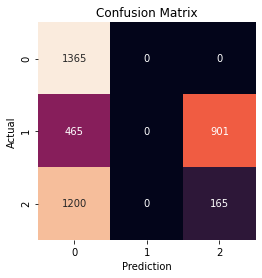

In [71]:
mat = confusion_matrix(y_pred, y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

See how RF classify the first 25 images

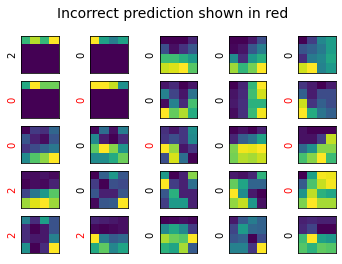

In [78]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(bridge4x4[i])
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(labels[y_pred[i]].split()[-1],
                   color='black' if y_pred[i] == y[i] else 'red')
fig.suptitle('Incorrect prediction shown in red', size=14);

##Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set

In [0]:
X_train_reduced = best_model.transform(X_bridge_train)
X_test_reduced = best_model.transform(X_bridge_test)

Perform cross validation using subset size 500

In [36]:
cross_val_score(RF_bridge, X_train_reduced[:500], y_bridge_train[:500], cv=3, scoring='accuracy').mean()

0.9020032224707212

Fit to training model

In [37]:
RF_bridge.fit(X_train_reduced, y_bridge_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Test the model using testing set

In [38]:
RF_bridge.score(X_test_reduced, y_bridge_test)

0.9023596419853539

The performance produce higher error when using K-Means as dimensionality reduction.

## Search for the number of clusters that provides the best performance.

In [39]:
from sklearn.pipeline import Pipeline

for n_clusters in range(1,11):
    pipe_bridge = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=n_clusters)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    pipe_bridge.fit(X_bridge_train, y_bridge_train)
    print(n_clusters, pipe_bridge.score(X_bridge_test, y_bridge_test))

1 0.6517493897477624
2 0.8966639544344996
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0
10 1.0


## This can be seen clearly that, n_clusters = 3 provides the best performance.

##With Gaussian Mixtures

Apply PCA (99% variataion)

In [40]:
pca = PCA(0.99)
X_bridge_pca = pca.fit_transform(X_bridge)

pca.n_components_

2

In [41]:
X_bridge_pca.shape

(4096, 2)

Let's train a Gaussian mixture model on the training set

In [42]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X_bridge_pca)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Let's look at the parameters that the EM algorithm estimated:

In [43]:
gm.weights_

array([0.33325195, 0.33349609, 0.33325195])

In [44]:
gm.means_

array([[ 9.76841849, -1.04822152],
       [-6.49080233, -4.23657971],
       [-3.27286099,  5.28790496]])

Did the algorithm actually converge?

In [45]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [46]:
gm.n_iter_

2

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use `predict()` method or the `predict_proba()` method:

In [47]:
gm.predict(X_bridge_pca)

array([2, 0, 0, ..., 2, 0, 0])

In [48]:
gm.predict_proba(X_bridge_pca)

array([[2.94324555e-50, 9.27671956e-21, 1.00000000e+00],
       [1.00000000e+00, 5.14357467e-55, 2.38233395e-35],
       [1.00000000e+00, 3.11924355e-47, 3.15826200e-44],
       ...,
       [1.44209767e-41, 1.68631039e-17, 1.00000000e+00],
       [1.00000000e+00, 5.00506597e-62, 1.60821055e-52],
       [1.00000000e+00, 2.16643396e-62, 1.87057121e-41]])

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [0]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

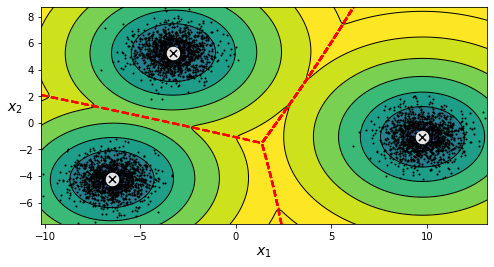

In [50]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X_bridge_pca)
plt.show()

## Anomaly Detection using Gaussian Mixtures

Gaussian Mixtures can be used for _anomaly detection_: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [0]:
densities = gm.score_samples(X_bridge_pca)
density_threshold = np.percentile(densities, 4)
anomalies = X_bridge_pca[densities < density_threshold]

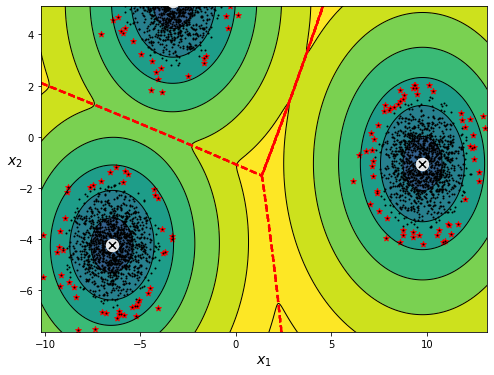

In [52]:
plt.figure(figsize=(8, 6))

plot_gaussian_mixture(gm, X_bridge_pca)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()